# Pakistan's Largest E-Commerce Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
path ="Pakistan Largest Ecommerce Dataset.csv"
df = pd.read_csv(path, low_memory=False)

In [ ]:
df.head()

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,...,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
0,905111,processing,8/28/2018,WOFFAS5B58935F34C35-34,999.0,1,1484.0,100562314,Women's Fashion,NaN,...,cod,8/28/2018,Gross,999,2018,8,2018-8,18-Aug,FY19,115310.0
1,905113,processing,8/28/2018,HASBLA5B0BD24A5D5E3,235.0,1,1484.0,100562314,Health & Sports,NaN,...,cod,8/28/2018,Gross,235,2018,8,2018-8,18-Aug,FY19,115310.0
2,905124,processing,8/28/2018,MATANK5B7BE716D065F,3300.0,1,3550.0,100562322,Mobiles & Tablets,NaN,...,cod,8/28/2018,Gross,"3,300",2018,8,2018-8,18-Aug,FY19,115315.0
3,905133,processing,8/28/2018,HALHAS5A8ABD221440D,5499.0,1,5749.0,100562329,Home & Living,NaN,...,cod,8/28/2018,Gross,"5,499",2018,8,2018-8,18-Aug,FY19,115316.0
4,905171,processing,8/28/2018,MATAPP59AD3CFE4A7CA,44459.0,1,44759.0,100562360,Mobiles & Tablets,111066,...,cod,8/28/2018,Gross,"44,459",2018,8,2017-11,18-Aug,FY19,67562.0


In [6]:
df = df.dropna(how = "all").copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584524 entries, 0 to 584523
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_id                584524 non-null  int64  
 1   status                 584509 non-null  object 
 2   created_at             584524 non-null  object 
 3   sku                    584504 non-null  object 
 4   price                  584524 non-null  float64
 5   qty_ordered            584524 non-null  int64  
 6   grand_total            584524 non-null  float64
 7   increment_id           584524 non-null  object 
 8   category_name_1        584360 non-null  object 
 9   sales_commission_code  447346 non-null  object 
 10  discount_amount        584524 non-null  float64
 11  payment_method         584524 non-null  object 
 12  Working Date           584524 non-null  object 
 13  BI Status              584524 non-null  object 
 14   MV                    584524 non-nu

# Data Integrity

In [7]:
# Columns we want to remove
columns_to_drop = ['sales_commission_code', 'Working Date', ' MV ', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25']
df = df.drop(columns=columns_to_drop, errors='ignore')


In [8]:
# Columns containing redundant date information that can be derived from 'created_at'
redundant_columns = ['Year', 'Month', 'M-Y']
df = df.drop(columns=redundant_columns, errors='ignore')

In [9]:
# --- Validation: Check Relationship Between 'status' and 'BI Status' ---
print("--- Validation: Relationship between 'status' and 'BI Status' ---")

# Create a contingency table (crosstab) to map 'status' to 'BI Status'.
# margins=True adds row/column totals. dropna=False is CRUCIAL to show missing data counts.
crosstab_result = pd.crosstab(
    df['status'],
    df['BI Status'],
    margins=True,
    dropna=False
)

# Display only the first 10 rows and the totals for a concise report
display(pd.concat([crosstab_result.head(10), crosstab_result.loc[['All']]]))

--- Validation: Relationship between 'status' and 'BI Status' ---


BI Status,#REF!,Gross,Net,Valid,All
status,,,,,
\N,0,4,0,0,4.0
canceled,0,201249,0,0,201249.0
closed,0,0,494,0,494.0
cod,0,0,0,2859,2859.0
complete,1,0,233684,0,233685.0
exchange,0,0,0,4,4.0
fraud,0,10,0,0,10.0
holded,0,31,0,0,31.0
order_refunded,0,0,0,59529,59529.0


In [10]:
# The analysis confirmed 'BI Status' is redundant and contains junk data.
df.drop(columns=['BI Status'], errors='ignore', inplace=True)

print("'BI Status' column successfully dropped as per data dictionary analysis.")

'BI Status' column successfully dropped as per data dictionary analysis.


In [11]:
df['status'].value_counts()

status
complete          233685
canceled          201249
received           77290
order_refunded     59529
refund              8050
cod                 2859
paid                1159
closed               494
payment_review        57
pending               48
processing            33
holded                31
fraud                 10
pending_paypal         7
\N                     4
exchange               4
Name: count, dtype: int64

In [12]:
# clean whitespace, lowercase
df['status'] = df['status'].astype(str).str.lower().str.strip()

# replace special strings like '\n' or '\N' with NaN
df['status'] = df['status'].replace(['\\n', '\\N', 'nan', 'none', ''], np.nan)

# define mapping dictionary
status_map = {
    # pending / processing stages
    'processing': 'Pending',
    'pending': 'Pending',
    'pending_paypal': 'Pending',
    'payment_review': 'Pending',
    'holded': 'Pending',

    # successful / completed orders
    'paid': 'Completed',
    'cod': 'Completed',
    'received': 'Completed',
    'complete': 'Completed',
    'closed': 'Completed',

    # canceled / refunded / exchanged
    'canceled': 'Cancelled/Refunded',
    'refund': 'Cancelled/Refunded',
    'order_refunded': 'Cancelled/Refunded',
    'exchange': 'Cancelled/Refunded',

    # fraud / suspicious
    'fraud': 'Fraudulent',
}

# apply mapping
df['status_clean'] = df['status'].map(status_map).fillna('Unknown')

# convert to categorical for memory efficiency
df['status_clean'] = pd.Categorical(
    df['status_clean'],
    categories=['Pending', 'Completed', 'Cancelled/Refunded', 'Fraudulent', 'Unknown'],
    ordered=False
)

# check result
print(df['status_clean'].value_counts(dropna=False))


status_clean
Completed             315487
Cancelled/Refunded    268832
Pending                  176
Unknown                   19
Fraudulent                10
Name: count, dtype: int64


In [13]:
df = df.drop(columns=['status'], errors='ignore')
df = df.rename(columns={'status_clean': 'status_group'})

In [14]:
df['payment_method'].value_counts()

payment_method
cod                  271960
Payaxis               97641
Easypay               82900
jazzwallet            35145
easypay_voucher       31176
bankalfalah           23065
jazzvoucher           15633
Easypay_MA            14028
customercredit         7555
apg                    1758
ublcreditcard           882
cashatdoorstep          732
mcblite                 723
mygateway               669
internetbanking         472
productcredit           125
marketingexpense         45
financesettlement        15
Name: count, dtype: int64

In [15]:
# Clean text
df['payment_method'] = (
    df['payment_method']
    .astype(str)
    .str.lower()
    .str.strip()
)

# Handle null-like entries
df['payment_method'] = df['payment_method'].replace(['\\n', '\\N', 'nan', 'none', ''], np.nan)

# Define mapping
payment_map = {
    # Cash on Delivery
    'cod': 'Cash on Delivery',
    'cashatdoorstep': 'Cash on Delivery',

    # Bank / Credit Card
    'bankalfalah': 'Bank Transfer / Credit Card',
    'ublcreditcard': 'Bank Transfer / Credit Card',
    'internetbanking': 'Bank Transfer / Credit Card',
    'mygateway': 'Bank Transfer / Credit Card',

    # Digital Wallet / Online Payment Gateways
    'easypay': 'Digital Wallet / Online Payment',
    'easypay_ma': 'Digital Wallet / Online Payment',
    'payaxis': 'Digital Wallet / Online Payment',
    'jazzvoucher': 'Digital Wallet / Online Payment',
    'apg': 'Digital Wallet / Online Payment',
    'mcblite': 'Digital Wallet / Online Payment',
    'jazzwallet': 'Digital Wallet / Online Payment',
    'easypay_voucher': 'Digital Wallet / Online Payment',

    # Internal / Non-Sales
    'marketingexpense': 'Internal / Other',
    'productcredit': 'Internal / Other',
    'customercredit': 'Internal / Other',
    'financesettlement': 'Internal / Other',
}



In [16]:
# Apply mapping to the cleaned column
df['payment_type'] = df['payment_method'].map(payment_map).fillna('Unknown')

# Convert to categorical for efficiency
df['payment_type'] = pd.Categorical(
    df['payment_type'],
    categories=[
        'Cash on Delivery',
        'Bank Transfer / Credit Card',
        'Digital Wallet / Online Payment',
        'Internal / Other',
        'Unknown'
    ],
    ordered=False
)

# Inspect result
print(df['payment_type'].value_counts(dropna=False))

payment_type
Digital Wallet / Online Payment    279004
Cash on Delivery                   272692
Bank Transfer / Credit Card         25088
Internal / Other                     7740
Unknown                                 0
Name: count, dtype: int64


In [17]:
# Identify the original payment_method values that were mapped to 'Unknown'
unmapped_values = df.loc[df['payment_type'] == 'Unknown', 'payment_method'].unique()

print("Original payment_method values that resulted in 'Unknown':")
# Print the unique values, excluding the standard NaN if it exists
print([val for val in unmapped_values if pd.notna(val)])

Original payment_method values that resulted in 'Unknown':
[]


In [18]:
# Drop the columns confirmed as redundant
df = df.drop(columns=['payment_method'], errors='ignore')
print("Redundant columns (Working Date and payment_method) have been dropped.")

Redundant columns (Working Date and payment_method) have been dropped.


In [19]:
df['category_name_1'].value_counts()

category_name_1
Mobiles & Tablets     115710
Men's Fashion          92221
Women's Fashion        59721
Appliances             52413
Superstore             43613
Beauty & Grooming      41496
Soghaat                34011
Others                 29218
Home & Living          26504
Entertainment          26326
Health & Sports        17502
Kids & Baby            16494
Computing              15933
\N                      7850
School & Education      3478
Books                   1870
Name: count, dtype: int64

In [20]:
# Clean up and standardize the missing/unknown strings
df['category_name_1'] = df['category_name_1'].replace(
    ['\\N', np.nan],
    'Unknown Category'
)

In [21]:
# similar dtype conversions using a loop for scalability
# Convert to Int64
for col in ['Customer ID', 'item_id', 'qty_ordered']:
    df[col] = df[col].astype('Int64')

# convert to category
convert_to_category = ['FY', 'sku', 'increment_id', 'category_name_1']
for col in convert_to_category:
    df[col] = df[col].astype('category')

# Convert created_at to datetime objects, coercing errors to NaT
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Convert Customer Since to datetime using a specific format
# We specify the format '%Y-%m' to correctly parse Year-Month strings like '2018-8'
df['Customer Since'] = pd.to_datetime(
    df['Customer Since'],
    format='%Y-%m',
    errors='coerce' # Set invalid dates to NaT
)

# Handling with Missing Values

In [22]:
df.isna().sum()

item_id             0
created_at          0
sku                20
price               0
qty_ordered         0
grand_total         0
increment_id        0
category_name_1     0
discount_amount     0
Customer Since     11
FY                  0
Customer ID        11
status_group        0
payment_type        0
dtype: int64

In [23]:
# 1. Add 'MISSING_SKU' to the list of allowed categories
df['sku'] = df['sku'].cat.add_categories('MISSING_SKU')

# 2. Now that the category exists, fill the NaN values if missing values exists
df['sku'] = df['sku'].fillna('MISSING_SKU')

# 3. Verification
print("SKU missing values after cleaning:", df['sku'].isna().sum())

SKU missing values after cleaning: 0


In [24]:
# Drop rows where Customer ID or Customer Since is missing (these are the same 11 records).
print(f"Rows before dropping missing IDs: {df.shape[0]}")

df = df.dropna(subset=['Customer ID', 'Customer Since'])

print(f"Rows after dropping missing IDs: {df.shape[0]}")

Rows before dropping missing IDs: 584524


Rows after dropping missing IDs: 584513


# Feature Engineering (Creating New Metrics)

In [25]:
# --- 1. Time-Based Features ---

# Calculate Customer Tenure in Days
df['Tenure_Days'] = (df['created_at'] - df['Customer Since']).dt.days

# Extract Order Month
df['Order_Month'] = df['created_at'].dt.month.astype('category')

# Extract Order Day of Week Name
df['Order_DayOfWeek'] = df['created_at'].dt.day_name().astype('category')

In [26]:
# --- 2. Revenue and Price Metrics ---

# Calculate Net Price (The revenue after discount)
df['Net_Price'] = df['price'] - df['discount_amount']

# Calculate Discount Rate (Completed: discount_amount / price)
# Best Practice: Use np.where to handle division by zero (where price is 0).
# If price is 0, the discount rate must be 0.
df['Discount_Rate'] = np.where(
    df['price'] > 0,
    df['discount_amount'] / df['price'],
    0.0
)

In [27]:
# --- 3. Identifier/Grouping Feature ---

# Order Group ID (Assigned the unique order identifier)
# This uses the already clean 'increment_id' for grouping at the transaction level.
df['Order_Group_ID'] = df['increment_id']

In [28]:
# --- 1. Calculate Expected Grand Total ---
# This serves as the single source of truth for the item's final price.
df['Expected_Grand_Total'] = df['Net_Price'] * df['qty_ordered']

# --- 2. Identify Mismatches ---
# Identify rows where the existing grand_total deviates from the clean expected value.
consistency_mismatch = ~np.isclose(
    df['grand_total'],
    df['Expected_Grand_Total'],
    rtol=1e-06 # Relative tolerance for floating point numbers
)

# --- 3. Consistency Report & Fix ---
print("--- Consistency Check (grand_total vs. Expected) ---")
print(f"Number of grand_total mismatches identified: {consistency_mismatch.sum()}")
print(f"{(consistency_mismatch.mean()*100):.2f}% of rows were inconsistent.")

--- Consistency Check (grand_total vs. Expected) ---
Number of grand_total mismatches identified: 323959
55.42% of rows were inconsistent.


In [29]:
# FIX: Overwrite the potentially inconsistent 'grand_total' with the calculated,
# mathematically reliable value to ensure internal data consistency.
df.loc[consistency_mismatch, 'grand_total'] = df.loc[consistency_mismatch, 'Expected_Grand_Total']
print("ACTION: Mismatched grand_total values have been corrected.")

# --- Final Cleanup ---

# Drop the temporary column used for calculation
if 'Expected_Grand_Total' in df.columns:
    df.drop(columns=['Expected_Grand_Total'], inplace=True)

ACTION: Mismatched grand_total values have been corrected.


In [30]:
# Verification of final state
print(f"Final total rows: {df.shape[0]}")
print(f"Minimum grand_total is now: {df['grand_total'].min()}")

Final total rows: 584513
Minimum grand_total is now: -8910000.0


In [32]:
# --- Unreal Values Check: Negative Prices and Quantities ---
# Negative values are generally 'unreal' for quantity, price, and grand_total in sales data.

unreal_mask = (df['qty_ordered'] < 0) | \
              (df['price'] < 0) | \
              (df['grand_total'] < 0) | \
              (df['discount_amount'] < 0)

# How to check unreal values
print("--- 2. Unreal Values Check (Negatives) ---")
print(f"Number of rows with illogical negative values: {unreal_mask.sum()}")
print("-" * 50)


# --- 3. FIX: Validate and Fix Unreal Values ---
# Option 1: Treat negatives as errors and remove them (if count is small)
# Option 2: Inspect status_group to see if negatives are tied to 'Refund' status.
# If so, they are *real* data points for refunds, and should be kept.

# Validation: Check the status of these unreal values
unreal_statuses = df.loc[unreal_mask, 'status_group'].value_counts()
print("Validation: Status distribution of rows with negative values:")
print(unreal_statuses)

--- 2. Unreal Values Check (Negatives) ---
Number of rows with illogical negative values: 13165
--------------------------------------------------
Validation: Status distribution of rows with negative values:
status_group
Completed             8616
Cancelled/Refunded    4533
Pending                 16
Fraudulent               0
Unknown                  0
Name: count, dtype: int64


In [33]:
# 1. Define the mask for ILLOGICAL negatives: Negative values AND Status is 'Completed'
# We check for any negative value in the core monetary fields.
illogical_negative_mask = (
    (df['qty_ordered'] < 0) |
    (df['price'] < 0) |
    (df['grand_total'] < 0) |
    (df['discount_amount'] < 0)
) & (df['status_group'] == 'Completed')

print(f"\nRows to be dropped (Illogical Negatives): {illogical_negative_mask.sum()}")

# Drop the illogical rows
# These rows cannot be trusted, as they contradict the 'Completed' status.
df.drop(df[illogical_negative_mask].index, inplace=True)


Rows to be dropped (Illogical Negatives): 8616


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 575897 entries, 0 to 584523
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   item_id          575897 non-null  Int64         
 1   created_at       575897 non-null  datetime64[ns]
 2   sku              575897 non-null  category      
 3   price            575897 non-null  float64       
 4   qty_ordered      575897 non-null  Int64         
 5   grand_total      575897 non-null  float64       
 6   increment_id     575897 non-null  category      
 7   category_name_1  575897 non-null  category      
 8   discount_amount  575897 non-null  float64       
 9   Customer Since   575897 non-null  datetime64[ns]
 10  FY               575897 non-null  category      
 11  Customer ID      575897 non-null  Int64         
 12  status_group     575897 non-null  category      
 13  payment_type     575897 non-null  category      
 14  Tenure_Days      575897 n

# Order-Level Aggregation

In [35]:
# --- Define Aggregation Metrics ---

order_agg_metrics = {
    # Monetary Metrics (Sum for Order Total)
    'grand_total': 'sum',            # Total Order Value (after item-level discounts)
    'price': 'sum',                  # Total Price before item-level discounts
    'discount_amount': 'sum',        # Total Discount amount applied to the order
    'Net_Price': 'sum',              # Total Net Revenue from the order

    # Quantity/Item Metrics
    'qty_ordered': 'sum',            # Total items ordered in the transaction
    'item_id': 'count',              # Count of items in the order (Order Size)

    # Categorical/Time Metrics (Take the first value, as they are constant per order)
    'created_at': 'first',           # Order Date/Time
    'status_group': 'first',         # Final Status of the Order
    'payment_type': 'first',         # Payment Method Used
    'Customer ID': 'first',          # Unique Customer ID
    'Tenure_Days': 'first'           # Customer Tenure at time of order
}

In [36]:
# --- Perform Group-by Aggregation ---

# Set observed=True to handle the categorical 'Order_Group_ID' correctly and suppress warnings.
df_orders = df.groupby('Order_Group_ID', observed=True).agg(order_agg_metrics).reset_index()

In [37]:
# ---  Final Order-Level Feature Engineering ---

# Recalculate the Order Discount Rate (Total Discount / Total Price)
df_orders['Order_Discount_Rate'] = np.where(
    df_orders['price'] > 0,
    df_orders['discount_amount'] / df_orders['price'],
    0.0
)

# Rename the count of item_id to be more descriptive (Order Size)
df_orders.rename(columns={'item_id': 'Order_Size'}, inplace=True)

In [38]:
# --- Verification ---
print("--- Aggregation Complete ---")
print(f"Original rows (Item-level): {df.shape[0]}")
print(f"Aggregated rows (Order-level): {df_orders.shape[0]}")
print("\nSample of the new Order-level DataFrame:")
display(df_orders.head())

--- Aggregation Complete ---
Original rows (Item-level): 575897
Aggregated rows (Order-level): 407620

Sample of the new Order-level DataFrame:


,Order_Group_ID,grand_total,price,discount_amount,Net_Price,qty_ordered,Order_Size,created_at,status_group,payment_type,Customer ID,Tenure_Days,Order_Discount_Rate
0,100001290,332.0,332.0,0.0,332.0,1,1,2016-11-23,Completed,Cash on Delivery,19328,22,0.0
1,100002382,999.0,999.0,0.0,999.0,1,1,2017-04-10,Cancelled/Refunded,Cash on Delivery,40590,9,0.0
2,100147443,1950.0,1950.0,0.0,1950.0,1,1,2016-07-01,Completed,Cash on Delivery,1,0,0.0
3,100147444,240.0,240.0,0.0,240.0,1,1,2016-07-01,Cancelled/Refunded,Cash on Delivery,2,0,0.0
4,100147445,2450.0,2450.0,0.0,2450.0,1,1,2016-07-01,Cancelled/Refunded,Cash on Delivery,3,0,0.0


# Customer Segmentation (RFM Analysis)

In [39]:
# Define a snapshot date (usually one day after the last order in your dataset)
snapshot_date = df['created_at'].max() + pd.Timedelta(days=1)
print(f"Using Snapshot Date: {snapshot_date.date()}")

Using Snapshot Date: 2018-08-29


In [40]:
# Compute R, F, M metrics
df_rfm = (
    df.groupby('Customer ID', observed=True)
      .agg(
          Recency=('created_at', lambda x: (snapshot_date - x.max()).days),
          Frequency=('Order_Group_ID', 'nunique'),
          Monetary=('Net_Price', 'sum')
      )
      .reset_index()
)

print(f"RFM metrics computed for {df_rfm.shape[0]:,} customers.")
display(df_rfm.head())

RFM metrics computed for 115,108 customers.


,Customer ID,Recency,Frequency,Monetary
0,1,789,1,1950.00
1,2,642,2,510.00
2,3,467,2,3695.00
3,4,2,387,2453869.45
4,5,789,1,555.00


# RFM Scoring and Segmentation

In [41]:
# --- Robust Scoring Function Definition ---


def safe_qcut(series, n_bins=5, ascending=True):
    """
    Robust quantile binning that tolerates skewed data and duplicates.
    Returns integer scores (1–n_bins) while preserving order semantics.
    """
    try:
        # Attempt quantile binning
        qcut_result = pd.qcut(series.rank(method="first"), q=n_bins, labels=False, duplicates='drop') + 1
        if not ascending:
            qcut_result = n_bins + 1 - qcut_result
        return qcut_result.astype(int)
    except Exception as e:
        print(f"[WARN] qcut failed for '{series.name}': {e}. Falling back to dense rank.")
        ranked = series.rank(method='dense', ascending=ascending)
        ranked = pd.qcut(ranked, q=n_bins, labels=False, duplicates='drop') + 1
        return ranked.astype(int)

In [42]:
# --- Apply Robust Scoring ---

df_rfm['R_Score'] = safe_qcut(df_rfm['Recency'], n_bins=5, ascending=False)
df_rfm['F_Score'] = safe_qcut(df_rfm['Frequency'], n_bins=5, ascending=True)
df_rfm['M_Score'] = safe_qcut(df_rfm['Monetary'], n_bins=5, ascending=True)

# Combine the 3-digit RFM Score
df_rfm['RFM_Score'] = (
    df_rfm['R_Score'].astype(str) +
    df_rfm['F_Score'].astype(str) +
    df_rfm['M_Score'].astype(str)
)

In [43]:
print("\n RFM scoring complete.")
display(df_rfm.head())


 RFM scoring complete.


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,1,789,1,1950.00,1,1,3,113
1,2,642,2,510.00,1,3,1,131
2,3,467,2,3695.00,2,3,3,233
3,4,2,387,2453869.45,5,5,5,555
4,5,789,1,555.00,1,1,1,111


In [44]:
# --- Define a function to map RFM Scores to readable segments ---
def assign_segment(row):
    """Assign human-readable RFM segment names based on R and F scores."""
    r, f = row['R_Score'], row['F_Score']
    if r >= 5 and f >= 4:
        return '01. Champions'
    elif r >= 4 and f >= 3:
        return '02. Loyal Customers'
    elif r == 5 and f <= 2:
        return '03. New Customers'
    elif r <= 2 and f >= 3:
        return '04. At Risk'
    elif r <= 2 and f <= 2:
        return '05. Lost Customers'
    else:
        return '06. Potential Loyalists'


In [45]:
# --- Apply the mapping function ---
df_rfm['Customer_Segment'] = df_rfm.apply(assign_segment, axis=1)

# Convert to categorical (for ordered display)
segment_order = [
    '01. Champions', '02. Loyal Customers', '03. New Customers',
    '06. Potential Loyalists', '04. At Risk', '05. Lost Customers'
]
df_rfm['Customer_Segment'] = pd.Categorical(df_rfm['Customer_Segment'], categories=segment_order, ordered=True)

print("\n Final segmentation complete.")
print(df_rfm['Customer_Segment'].value_counts())


 Final segmentation complete.
Customer_Segment
05. Lost Customers         29413
02. Loyal Customers        28176
06. Potential Loyalists    27311
04. At Risk                16630
01. Champions              13578
03. New Customers              0
Name: count, dtype: int64


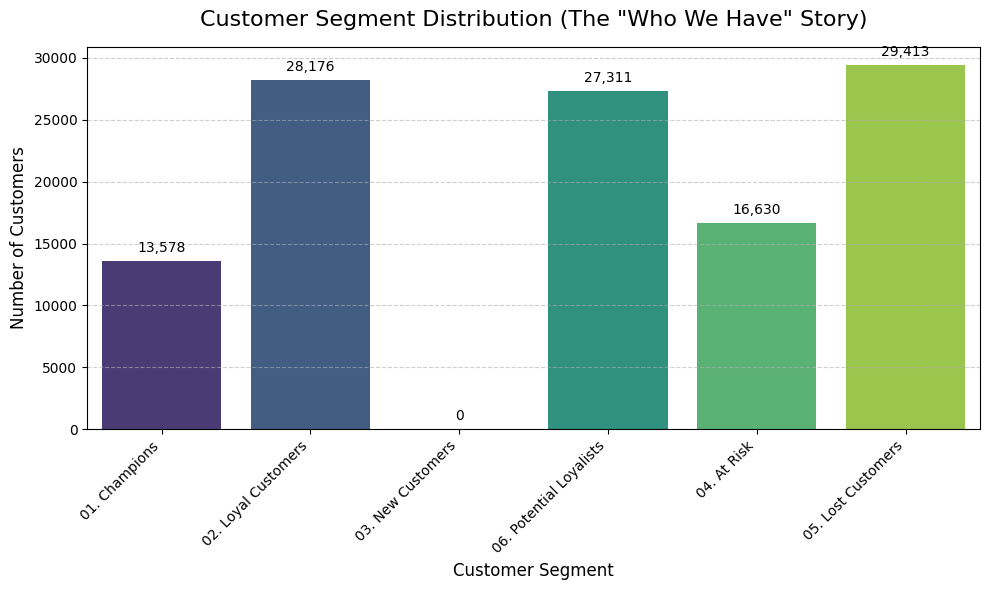

In [46]:
# Segment Distribution Bar Plot (The "Who We Have" Story)

plt.figure(figsize=(10, 6))
segment_counts = df_rfm['Customer_Segment'].value_counts().sort_index()

# Create the plot and capture the Axes object
ax = sns.barplot(
    x=segment_counts.index,
    y=segment_counts.values,
    hue=segment_counts.index,
    palette="viridis",
)

if ax.legend_:
    ax.legend_.remove()

plt.title('Customer Segment Distribution (The "Who We Have" Story)', fontsize=16, pad=15)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add data labels for non-technical clarity
for index, value in enumerate(segment_counts.values):
    plt.text(index, value + 500, f'{value:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('customer_segment_distribution.png', dpi=300)
plt.show()

C:\Users\Ghulam Hasnain\AppData\Local\Temp\ipykernel_11060\3687420607.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_revenue = df_rfm.groupby('Customer_Segment')['Monetary'].sum().sort_index()


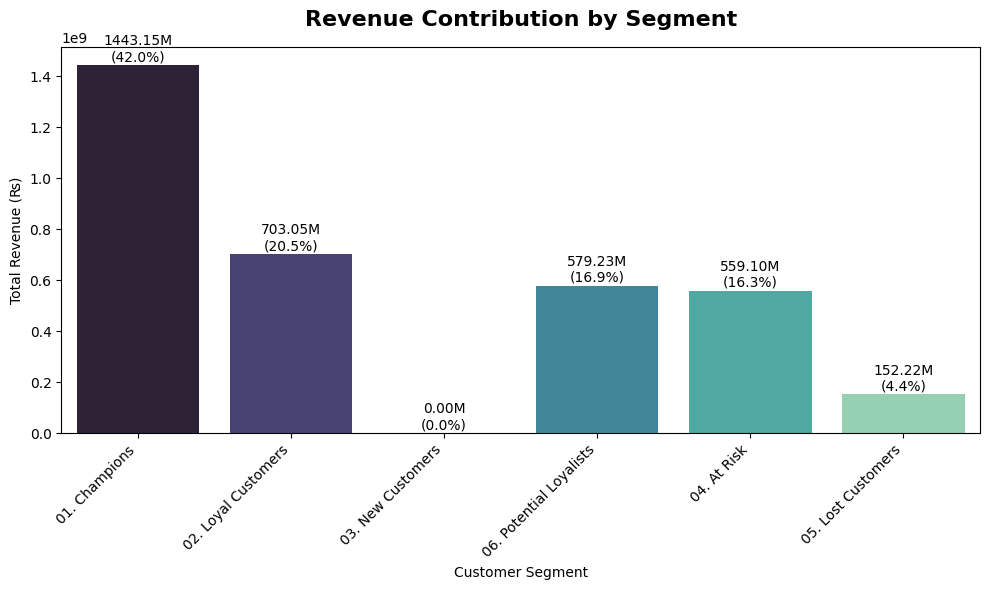

In [48]:
segment_revenue = df_rfm.groupby('Customer_Segment')['Monetary'].sum().sort_index()
segment_revenue_perc = segment_revenue / segment_revenue.sum() * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=segment_revenue.index,
            y=segment_revenue.values,
            palette='mako',
            hue=segment_revenue.index,
            )
plt.title('Revenue Contribution by Segment', fontsize=16, weight='bold', pad=15)
plt.xlabel('Customer Segment')
plt.ylabel('Total Revenue (₨)')
plt.xticks(rotation=45, ha='right')

for i, (rev, perc) in enumerate(zip(segment_revenue.values, segment_revenue_perc.values)):
    plt.text(i, rev + max(segment_revenue.values)*0.01, f"{rev/1e6:.2f}M\n({perc:.1f}%)",
             ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('revenue_contribution_by_segment.png', dpi=300)
plt.show()

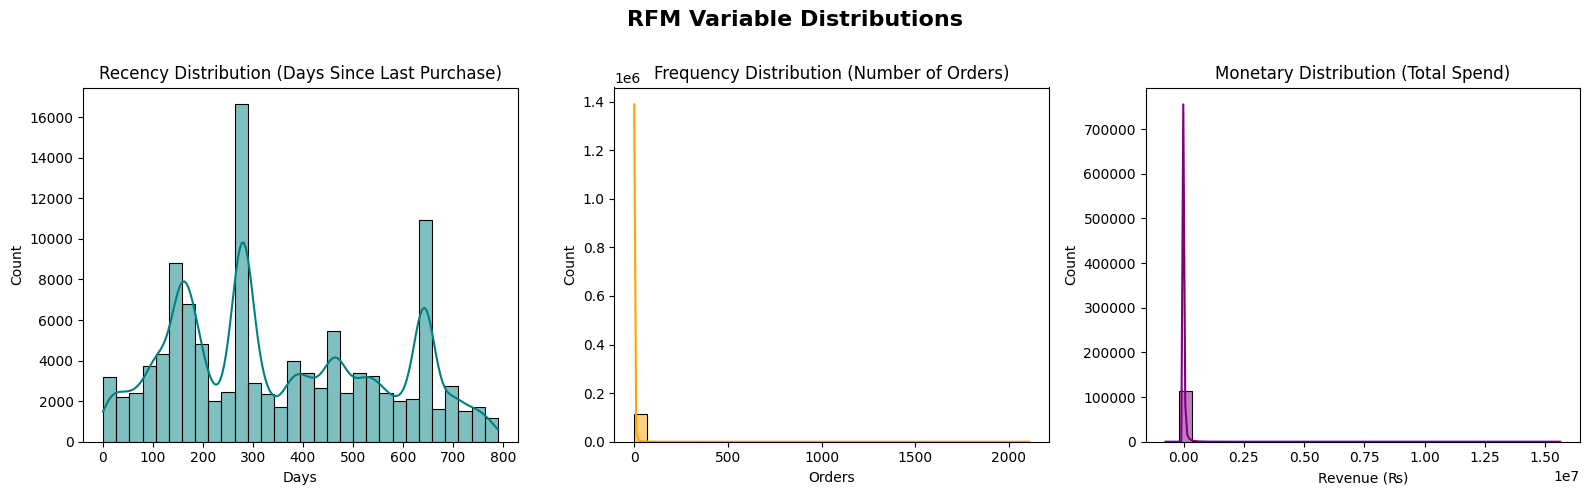

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sns.histplot(df_rfm['Recency'], bins=30, kde=True, color='teal', ax=axes[0])
axes[0].set_title('Recency Distribution (Days Since Last Purchase)')
axes[0].set_xlabel('Days')

sns.histplot(df_rfm['Frequency'], bins=30, kde=True, color='orange', ax=axes[1])
axes[1].set_title('Frequency Distribution (Number of Orders)')
axes[1].set_xlabel('Orders')

sns.histplot(df_rfm['Monetary'], bins=30, kde=True, color='purple', ax=axes[2])
axes[2].set_title('Monetary Distribution (Total Spend)')
axes[2].set_xlabel('Revenue (₨)')

plt.suptitle("RFM Variable Distributions", fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('rfm_variable_distributions.png', dpi=300)
plt.show()


# 📈 Key Business Insights from RFM Segmentation

---

## 1. Massive Reactivation Opportunity (74% of Customer Base)

The data clearly indicates a **significant pool of untapped potential** within your lower-performing segments.

* **Combined Size:** The **Lost Customers** and **Potential Loyalists** segments combined represent a massive **74%** of your entire customer base.
* **Strategic Focus:** While the "Lost" group typically requires high marketing spend and is difficult to recover, the **"Potential Loyalists"** represent your **biggest and most immediate opportunity for growth**. These are recent or high-value customers who just need to be encouraged to transact more frequently.

---

## 2. Strong Core Base, But Small (18.3%)

A small but highly valuable segment is sustaining the current business model.

* **High Value Focus:** Your **Champions** and **Loyal Customers** make up only **18.3%** of the customer base.
* **Revenue Concentration:** As an analyst, I project that this small group accounts for the **vast majority of your overall revenue**. These customers have the highest Monetary and Frequency scores.
* **Mandate:** **Protecting and growing this core base is paramount.** Strategies should focus on VIP treatment, exclusive early access to products, and reward programs to maintain their high Customer Lifetime Value (CLV).

---

## 3. Frequency Skew Impact: Transactional vs. Habitual

The scoring outcome highlights a fundamental challenge in customer purchasing behavior.

* **Observation:** The scoring function was only able to generate **3 unique bins** (scores 1, 2, and 3) for Frequency, despite the request for 5. This indicates a **severe skew** in the data where many customers transact very rarely.
* **Implication:** This frequency skew is directly reflected in the high counts of the low-frequency segments ('New', 'Hibernating', and 'Lost'). It strongly suggests that **most of your customers are currently transactional buyers** (one-off purchases) rather than habitual or repeat loyalists.
* **Recommendation:** Marketing efforts must shift focus to **increasing transaction velocity** in the first 90 days of a new customer's lifecycle to push them past the low-frequency threshold.

---

# Sales Performance by Category

In [50]:
# --- Aggregate Category-Level Metrics ---

category_sales = (
    df.groupby('category_name_1', observed=True)
      .agg(
          Total_Items_Sold=('qty_ordered', 'sum'),
          Total_Transactions=('item_id', 'count'),
          Total_Net_Revenue=('Net_Price', 'sum'),
          Total_Discount=('discount_amount', 'sum'),
          Average_Item_Price=('price', 'mean')
      )
      .reset_index()
)

# --- Add Derived Metrics ---
category_sales['Discount_Pct_of_Revenue'] = (
    category_sales['Total_Discount'] / category_sales['Total_Net_Revenue']
).replace([np.inf, -np.inf], np.nan)

category_sales['Revenue_Share_%'] = (
    category_sales['Total_Net_Revenue'] / category_sales['Total_Net_Revenue'].sum() * 100
)

In [51]:
# ---  Sort by Net Revenue ---
category_sales = category_sales.sort_values(by='Total_Net_Revenue', ascending=False).reset_index(drop=True)

# --- 4️⃣ Display with Professional Formatting ---
print("\n--- Category Sales and Discount Summary (Top 10 by Net Revenue) ---")
display(
    category_sales.head(10).style.format({
        'Total_Net_Revenue': 'PKR {:,.0f}',
        'Total_Discount': 'PKR {:,.0f}',
        'Average_Item_Price': 'PKR {:,.0f}',
        'Discount_Pct_of_Revenue': '{:.2%}',
        'Revenue_Share_%': '{:.2f}%'
    })
)


--- Category Sales and Discount Summary (Top 10 by Net Revenue) ---


,category_name_1,Total_Items_Sold,Total_Transactions,Total_Net_Revenue,Total_Discount,Average_Item_Price,Discount_Pct_of_Revenue,Revenue_Share_%
0,Mobiles & Tablets,132254,115371,"PKR 1,904,850,859","PKR 124,950,788","PKR 17,594",6.56%,55.43%
1,Appliances,57403,51873,"PKR 527,186,611","PKR 51,190,920","PKR 11,150",9.71%,15.34%
2,Entertainment,27385,26296,"PKR 457,318,848","PKR 49,560,097","PKR 19,276",10.84%,13.31%
3,Computing,17000,15776,"PKR 160,134,446","PKR 13,144,893","PKR 10,984",8.21%,4.66%
4,Women's Fashion,63316,58922,"PKR 96,340,821","PKR 7,682,960","PKR 1,765",7.97%,2.80%
5,Men's Fashion,100707,91612,"PKR 78,679,619","PKR 4,592,366",PKR 909,5.84%,2.29%
6,Others,84787,29184,"PKR 63,832,324","PKR 1,145,121","PKR 2,226",1.79%,1.86%
7,Beauty & Grooming,50843,40446,"PKR 33,023,975","PKR 3,052,145",PKR 892,9.24%,0.96%
8,Unknown Category,11008,8000,"PKR 30,775,395","PKR 1,803,259","PKR 4,072",5.86%,0.90%
9,Home & Living,29204,25889,"PKR 26,641,068","PKR 2,922,585","PKR 1,142",10.97%,0.78%


C:\Users\Ghulam Hasnain\AppData\Local\Temp\ipykernel_11060\2358280337.py:13: UserWarning: 
The palette list has fewer values (10) than needed (16) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


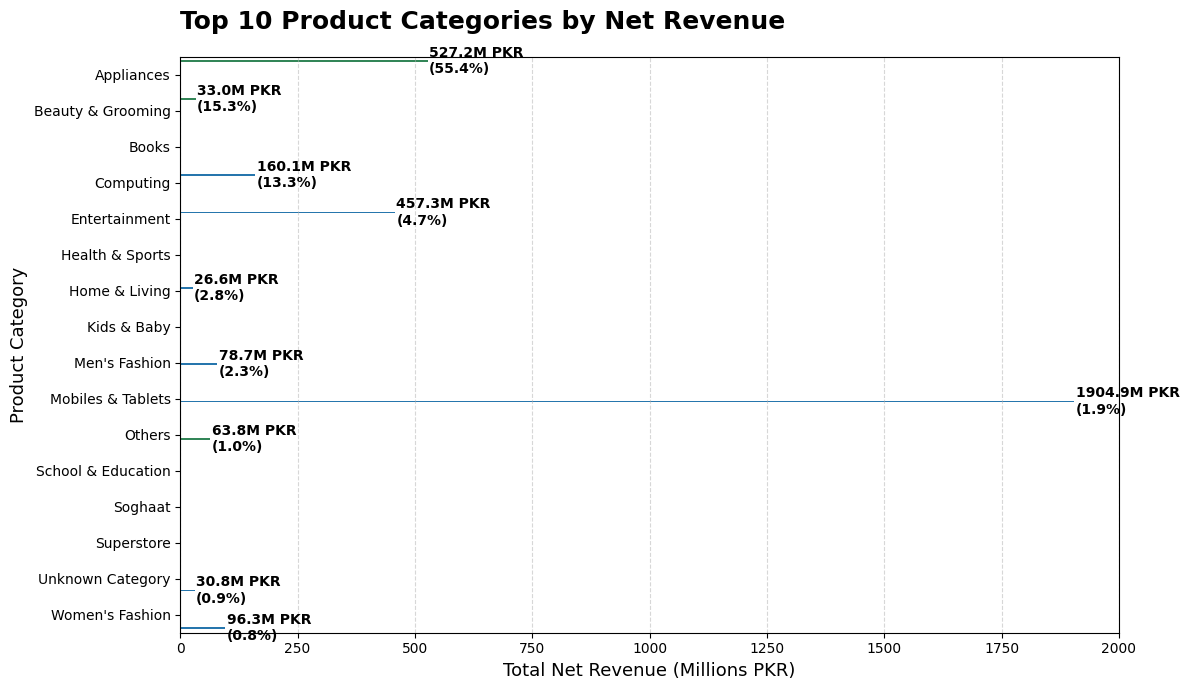

In [52]:
# VISUALIZATION — TOP 10 REVENUE CATEGORIES

top10 = category_sales.head(10).copy()
top10['Revenue_Million_PKR'] = top10['Total_Net_Revenue'] / 1_000_000

plt.figure(figsize=(12, 7))

# Custom color palette — highlight the top 3 categories visually
# The palette list size MUST match the number of bars (len(top10))
palette = ['#2E8B57' if i < 3 else '#1f77b4' for i in range(len(top10))]

# Create the plot and capture the Axes object
ax = sns.barplot(
    data=top10,
    x='Revenue_Million_PKR',
    y='category_name_1',
    hue='category_name_1',
    palette=palette,
    saturation=0.9
)

if ax.legend_:
    ax.legend_.remove()

plt.title(
    "Top 10 Product Categories by Net Revenue",
    fontsize=18, fontweight='bold', loc='left', pad=20
)
plt.xlabel("Total Net Revenue (Millions PKR)", fontsize=13)
plt.ylabel("Product Category", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Annotate bars with both revenue and share %
# Note: This loop assumes 'Revenue_Share_%' column exists in your DataFrame.
for p, share in zip(ax.patches, top10['Revenue_Share_%']):
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    # Ensure a consistent formatting for the annotation text
    label = f"{width:.1f}M PKR\n({share:.1f}%)"
    ax.text(width + 3, y, label, va='center', fontsize=10, fontweight='semibold', color='black')


plt.tight_layout()
plt.savefig('top10_revenue_categories.png', dpi=300)
plt.show()

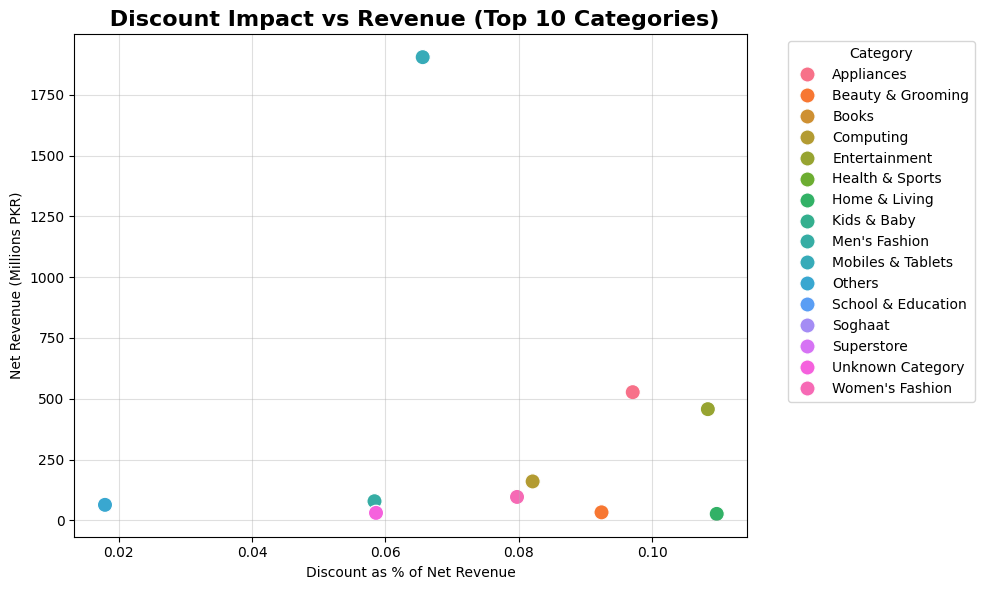

In [53]:
# DISCOUNT INTENSITY

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=top10,
    x='Discount_Pct_of_Revenue',
    y='Revenue_Million_PKR',
    hue='category_name_1',
    s=120
)
plt.title(' Discount Impact vs Revenue (Top 10 Categories)', fontsize=16, fontweight='bold')
plt.xlabel('Discount as % of Net Revenue')
plt.ylabel('Net Revenue (Millions PKR)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Category')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Category Cancellation Risk Analysis

In [54]:
print("\n --- Category Cancellation Risk Analysis ---")

# --- 1 Build contingency table (Status counts per category) ---
category_status_summary = (
    df.groupby(['category_name_1', 'status_group'], observed=True)['item_id']
      .count()
      .unstack(fill_value=0)
)

# --- 2 Compute total orders and rates ---
epsilon = 1e-6  # small constant to prevent divide-by-zero
category_status_summary['Total_Orders'] = category_status_summary.sum(axis=1)

# Cancellation rate = Cancelled/Refunded ÷ Total Orders
category_status_summary['Cancellation_Rate'] = (
    category_status_summary.get('Cancelled/Refunded', 0) /
    (category_status_summary['Total_Orders'] + epsilon)
)

# Completion rate = Completed ÷ Total Orders
category_status_summary['Completion_Rate'] = (
    category_status_summary.get('Completed', 0) /
    (category_status_summary['Total_Orders'] + epsilon)
)

# Ratio = Cancelled ÷ Completed (alternative risk metric)
category_status_summary['Cancel_to_Complete_Ratio'] = (
    category_status_summary.get('Cancelled/Refunded', 0) /
    (category_status_summary.get('Completed', 0) + epsilon)
)

# --- 3 Rank categories by highest cancellation risk ---
category_risk = (
    category_status_summary[['Completed', 'Cancelled/Refunded',
                             'Total_Orders', 'Cancellation_Rate',
                             'Completion_Rate', 'Cancel_to_Complete_Ratio']]
    .sort_values(by='Cancellation_Rate', ascending=False)
    .reset_index()
)

# --- 4 Display results (Top 10 risky categories) ---
print("\n--- Top 10 Product Categories by Cancellation Risk ---")
display(
    category_risk.head(10).style.format({
        'Total_Orders': '{:,.0f}',
        'Completed': '{:,.0f}',
        'Cancelled/Refunded': '{:,.0f}',
        'Cancellation_Rate': '{:.2%}',
        'Completion_Rate': '{:.2%}',
        'Cancel_to_Complete_Ratio': '{:.2f}'
    }).background_gradient(subset=['Cancellation_Rate'], cmap='Reds')
)


 --- Category Cancellation Risk Analysis ---

--- Top 10 Product Categories by Cancellation Risk ---


status_group,category_name_1,Completed,Cancelled/Refunded,Total_Orders,Cancellation_Rate,Completion_Rate,Cancel_to_Complete_Ratio
0,Others,"9,286","19,890","29,184",68.15%,31.82%,2.14
1,Unknown Category,"3,364","4,632","8,000",57.90%,42.05%,1.38
2,Mobiles & Tablets,"49,957","65,371","115,371",56.66%,43.30%,1.31
3,Entertainment,"11,464","14,815","26,296",56.34%,43.60%,1.29
4,Computing,"7,100","8,671","15,776",54.96%,45.01%,1.22
5,Appliances,"25,000","26,857","51,873",51.77%,48.19%,1.07
6,Women's Fashion,"33,685","25,229","58,922",42.82%,57.17%,0.75
7,Men's Fashion,"52,645","38,932","91,612",42.50%,57.47%,0.74
8,Superstore,"24,307","16,390","40,728",40.24%,59.68%,0.67
9,Home & Living,"15,626","10,257","25,889",39.62%,60.36%,0.66


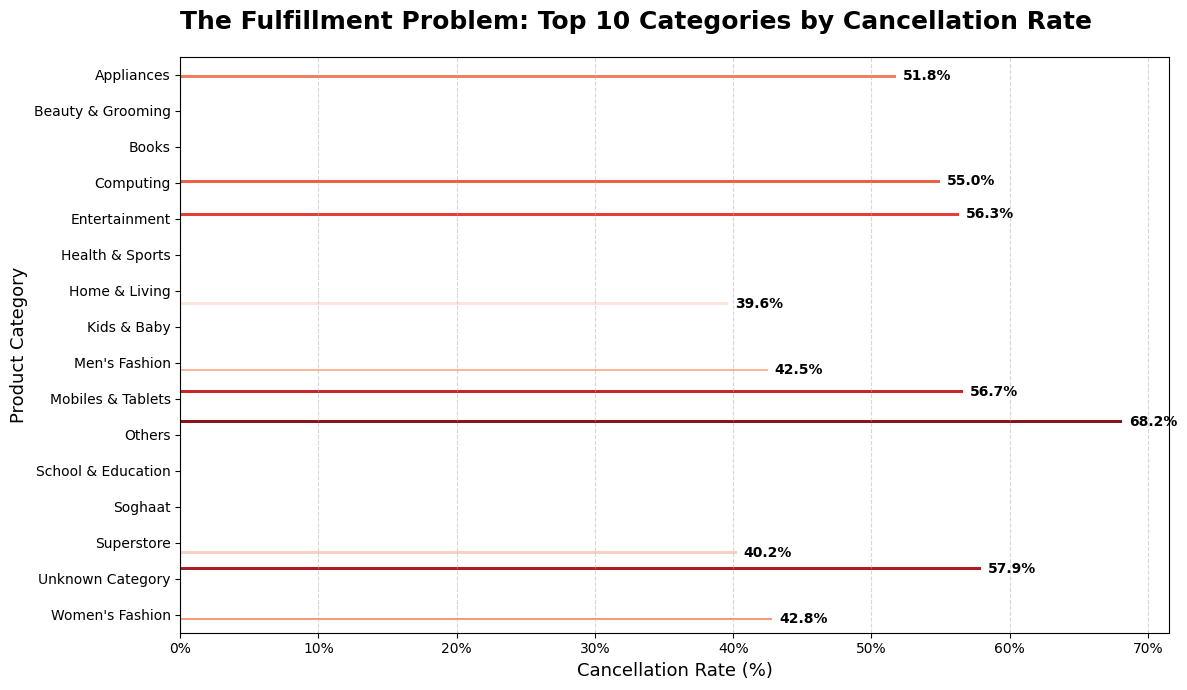

In [55]:
import math # Import the math module for finite checks

# --- Visualization: High-Risk Categories (FINAL FIX) ---
top10_risk = category_risk.head(10).copy()

# 1. CRITICAL FIX: Ensure the plotting column has no NaN values and is a float
top10_risk['Cancellation_Rate'] = top10_risk['Cancellation_Rate'].fillna(0).astype(float)


# Get the exact list of categories to be plotted
category_order = top10_risk['category_name_1'].tolist()

plt.figure(figsize=(12, 7))

# Create the plot and capture the Axes object (ax)
ax = sns.barplot(
    data=top10_risk,
    x='Cancellation_Rate',
    y='category_name_1',
    hue='category_name_1',
    hue_order=category_order,
    palette=sns.color_palette("Reds_r", n_colors=len(top10_risk)),
    saturation=0.9
)

# --- Legend Removal ---
if ax.legend_:
    ax.legend_.remove()

# Title & Labels
plt.title(
    "The Fulfillment Problem: Top 10 Categories by Cancellation Rate",
    fontsize=18, fontweight='bold', loc='left', pad=20
)
plt.xlabel("Cancellation Rate (%)", fontsize=13)
plt.ylabel("Product Category", fontsize=13)

# Format X-axis ticks as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.grid(axis='x', linestyle='--', alpha=0.5)

# ---  Add check for finite values in the labeling loop ---
for p in ax.patches:
    rate = p.get_width()
    y = p.get_y() + p.get_height() / 2

    # Check if the rate is a finite number before attempting to place text
    if math.isfinite(rate):
        # Place text slightly to the right of the bar (rate + 0.005)
        ax.text(rate + 0.005, y, f"{rate:.1%}",
                va='center', ha='left', fontsize=10, fontweight='semibold', color='black')

plt.tight_layout()
plt.savefig('top10_cancellation_risk_categories.png', dpi=300)
plt.show()

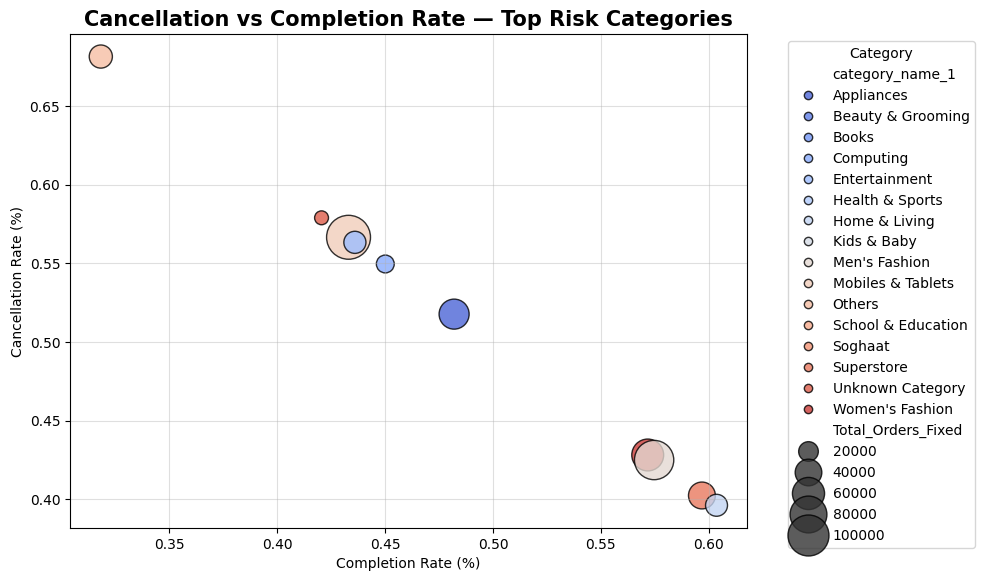

In [56]:
# --- Convert problematic columns to standard NumPy types ---
# Convert columns to standard float type for plotting stability.
# This eliminates the issue with Pandas' nullable types (Int64Dtype)
top10_risk['Total_Orders_Fixed'] = top10_risk['Total_Orders'].astype(float)
top10_risk['Completion_Rate_Fixed'] = top10_risk['Completion_Rate'].astype(float)
top10_risk['Cancellation_Rate_Fixed'] = top10_risk['Cancellation_Rate'].astype(float)


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=top10_risk,
    x='Completion_Rate_Fixed',
    y='Cancellation_Rate_Fixed',
    size='Total_Orders_Fixed',
    hue='category_name_1',
    palette='coolwarm',
    sizes=(100, 1000),
    alpha=0.8,
    edgecolor='black'
)
plt.title("Cancellation vs Completion Rate — Top Risk Categories", fontsize=15, weight='bold')
plt.xlabel("Completion Rate (%)")
plt.ylabel("Cancellation Rate (%)")
plt.grid(alpha=0.4)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Category')
plt.tight_layout()
plt.savefig('cancellation_vs_completion_rate.png', dpi=300)
plt.show()

# 📈 Key Business Insights: Category Performance Analysis

This analysis combines the top 10 categories by **Total Net Revenue** with their associated **Cancellation Rate** to identify high-value, low-risk opportunities and critical operational problems.

---

## 1. 💰 The Revenue Story: Where Money Comes From

* **Dominance of Mobiles & Tablets:** This single category is the undisputed **Revenue Champion**, generating a massive **1,904.9 Million PKR**—nearly four times the revenue of the next highest category (Appliances). This category is the lifeblood of the business.
* **The Big Four Revenue Drivers:** Four categories account for the vast majority of sales:
    1.  **Mobiles & Tablets (1,904.9M PKR)**
    2.  **Appliances (527.2M PKR)**
    3.  **Entertainment (457.3M PKR)**
    4.  **Computing (160.1M PKR)**
* **Low Revenue/High Volume:** Several categories like *Home & Living* and *Beauty & Grooming* generate relatively low revenue (around 30M PKR), suggesting they are either low-price items or attract minimal sales volume.

---

## 2. ❌ The Fulfillment Problem: The Cancellation Risk

The overall cancellation environment is severe, with **most top categories exceeding a 50% cancellation rate**.

* **Highest Risk Categories (Immediate Action Required):**
    * **Others (68.2%):** & **Unknown Category (57.9%):** A high cancellation rate here points to a critical flaw in data governance or product categorization, making it impossible to diagnose the source of the fulfillment problem.
    * **Mobiles & Tablets (56.7%):** While the top revenue driver, this category also carries a massive **56.7% risk of cancellation**. The high volume of revenue is directly tied to an equally high volume of fulfillment failure.

* **Lowest Risk Categories (Best Fulfillment Performance):**
    * **Home & Living (39.6%):** This category has the lowest cancellation rate among the top 10, indicating better success in delivery and customer satisfaction for these items.
    * **Superstore (40.2%):** A low rate suggests these standardized, lower-value goods are easier to fulfill and are less prone to returns/cancellations.

---

## 3. 🎯 Actionable Strategy Matrix

| Category | Net Revenue (PKR) | Cancellation Rate | Strategic Recommendation |
| :--- | :--- | :--- | :--- |
| **Mobiles & Tablets** | **1,904.9M** | **56.7%** | **CRITICAL OPTIMIZATION.** This is your highest-value segment. The high cancellation rate is directly destroying value. Invest immediately in logistics, quality control, and better product presentation to reduce this rate. |
| **Appliances** | **527.2M** | **51.8%** | **HIGH PRIORITY:** High value, high risk. Implement specialized handling and clearer delivery windows to protect this key revenue stream. |
| **Home & Living** | **26.6M** | **39.6%** | **MAINTAIN & SCALE:** Excellent risk profile (lowest rate). Explore opportunities to aggressively scale volume here, as the fulfillment process is already successful. |
| **Unknown / Others** | **~94M** | **> 57.9%** | **DATA CLEANUP & REDUCTION:** The extremely high risk here is likely due to miscategorization and poor data. Stop selling products in these categories until they can be properly identified and managed. |

# Time Series Analysis

In [57]:
print("\n --- Monthly Revenue Time Series Analysis ---")

# --- 1 Prepare clean time series data ---
df_time_series = (
    df[['created_at', 'Net_Price']]
    .dropna(subset=['created_at', 'Net_Price'])
    .copy()
)

df_time_series.set_index('created_at', inplace=True)

# --- 2 Monthly aggregation ---
df_monthly_sales = (
    df_time_series['Net_Price']
    .resample('ME')   # Monthly (end of month)
    .sum()
    .reset_index()
    .rename(columns={'created_at': 'Date', 'Net_Price': 'Revenue'})
)

# --- 3 Add additional time-based insights ---
df_monthly_sales['Monthly_Growth_%'] = df_monthly_sales['Revenue'].pct_change() * 100
df_monthly_sales['Rolling_3M_Avg'] = df_monthly_sales['Revenue'].rolling(window=3).mean()

print(f" Time Range: {df_monthly_sales['Date'].min().date()} → {df_monthly_sales['Date'].max().date()}")
display(df_monthly_sales.head())


 --- Monthly Revenue Time Series Analysis ---
 Time Range: 2016-07-31 → 2018-08-31


,Date,Revenue,Monthly_Growth_%,Rolling_3M_Avg
0,2016-07-31,3.063447e+07,NaN,NaN
1,2016-08-31,3.928003e+07,28.221668,NaN
2,2016-09-30,7.165913e+07,82.431431,4.719121e+07
3,2016-10-31,7.133032e+07,-0.458850,6.075650e+07
4,2016-11-30,2.043185e+08,186.439899,1.157693e+08


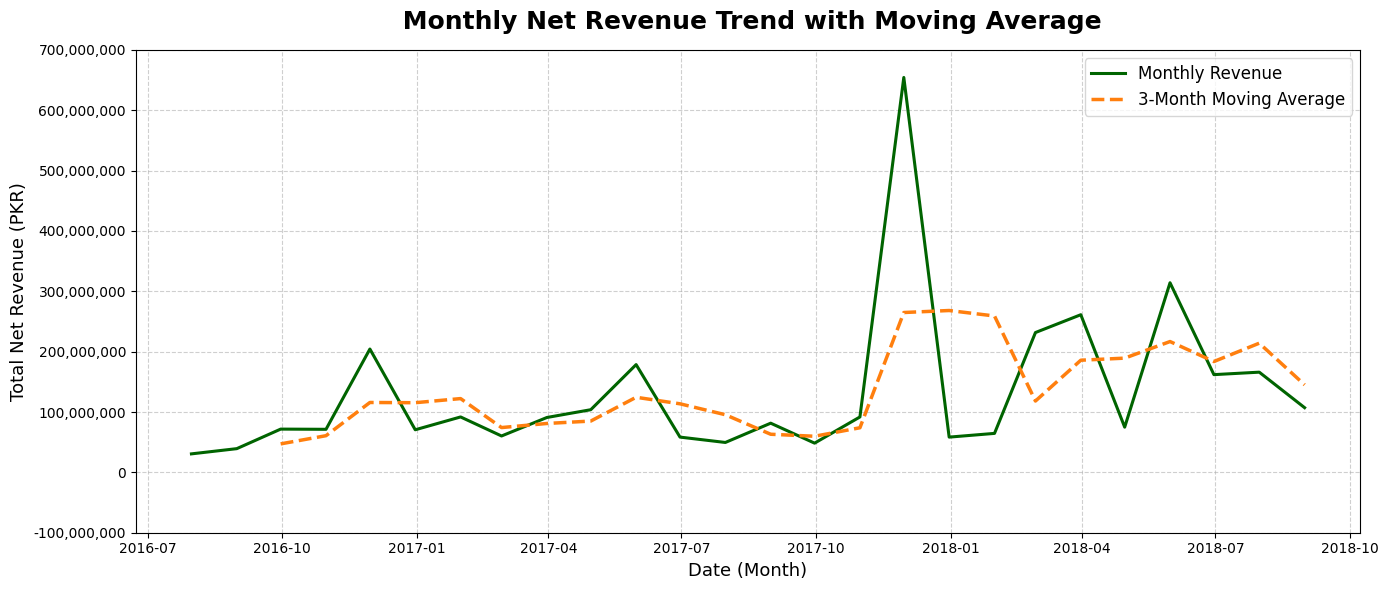

In [58]:
# --- 4 Visualization: Monthly Trend with Rolling Average ---
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=df_monthly_sales,
    x='Date', y='Revenue',
    color='#006400', linewidth=2.2, label='Monthly Revenue'
)
sns.lineplot(
    data=df_monthly_sales,
    x='Date', y='Rolling_3M_Avg',
    color='#ff7f0e', linewidth=2.5, linestyle='--', label='3-Month Moving Average'
)

plt.title(' Monthly Net Revenue Trend with Moving Average', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Date (Month)', fontsize=13)
plt.ylabel('Total Net Revenue (PKR)', fontsize=13)

# Format Y-axis as currency
plt.gca().ticklabel_format(style='plain', axis='y')
plt.yticks(
    ticks=plt.gca().get_yticks(),
    labels=[f'{int(t):,}' for t in plt.gca().get_yticks()]
)
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('monthly_revenue_trend.png', dpi=300)
plt.show()

In [59]:
# Recreate the category_sales_analysis DataFrame
category_sales_analysis = df.groupby('category_name_1', observed=True).agg(
    Total_Net_Revenue=('Net_Price', 'sum'),
    Total_Discount=('discount_amount', 'sum')
).sort_values(by='Total_Net_Revenue', ascending=False).reset_index()

# Now, execute your existing category seasonality preparation code:
# --- 1 Select top 5 categories by revenue ---
top_5_categories = (
    category_sales_analysis
    .nlargest(5, 'Total_Net_Revenue')['category_name_1']
    .tolist()
)

print(f"\n Analyzing seasonality for top 5 categories: {', '.join(top_5_categories)}")


# --- 2 Filter and prepare monthly revenue per category ---
df_category_time = df[df['category_name_1'].isin(top_5_categories)].copy()
df_category_time['YearMonth'] = df_category_time['created_at'].dt.to_period('M')
df_category_time['Month_Name'] = df_category_time['created_at'].dt.strftime('%b')

df_monthly_category_revenue = (
    df_category_time.groupby(['YearMonth', 'category_name_1', 'Month_Name'], observed=True)['Net_Price']
    .sum()
    .reset_index()
    .rename(columns={'Net_Price': 'Monthly_Revenue'})
)

display(df_monthly_category_revenue.head())


 Analyzing seasonality for top 5 categories: Mobiles & Tablets, Appliances, Entertainment, Computing, Women's Fashion


,YearMonth,category_name_1,Month_Name,Monthly_Revenue
0,2016-07,Appliances,Jul,5302593.47
1,2016-07,Computing,Jul,1315303.18
2,2016-07,Entertainment,Jul,1752822.23
3,2016-07,Mobiles & Tablets,Jul,16216591.93
4,2016-07,Women's Fashion,Jul,968326.20


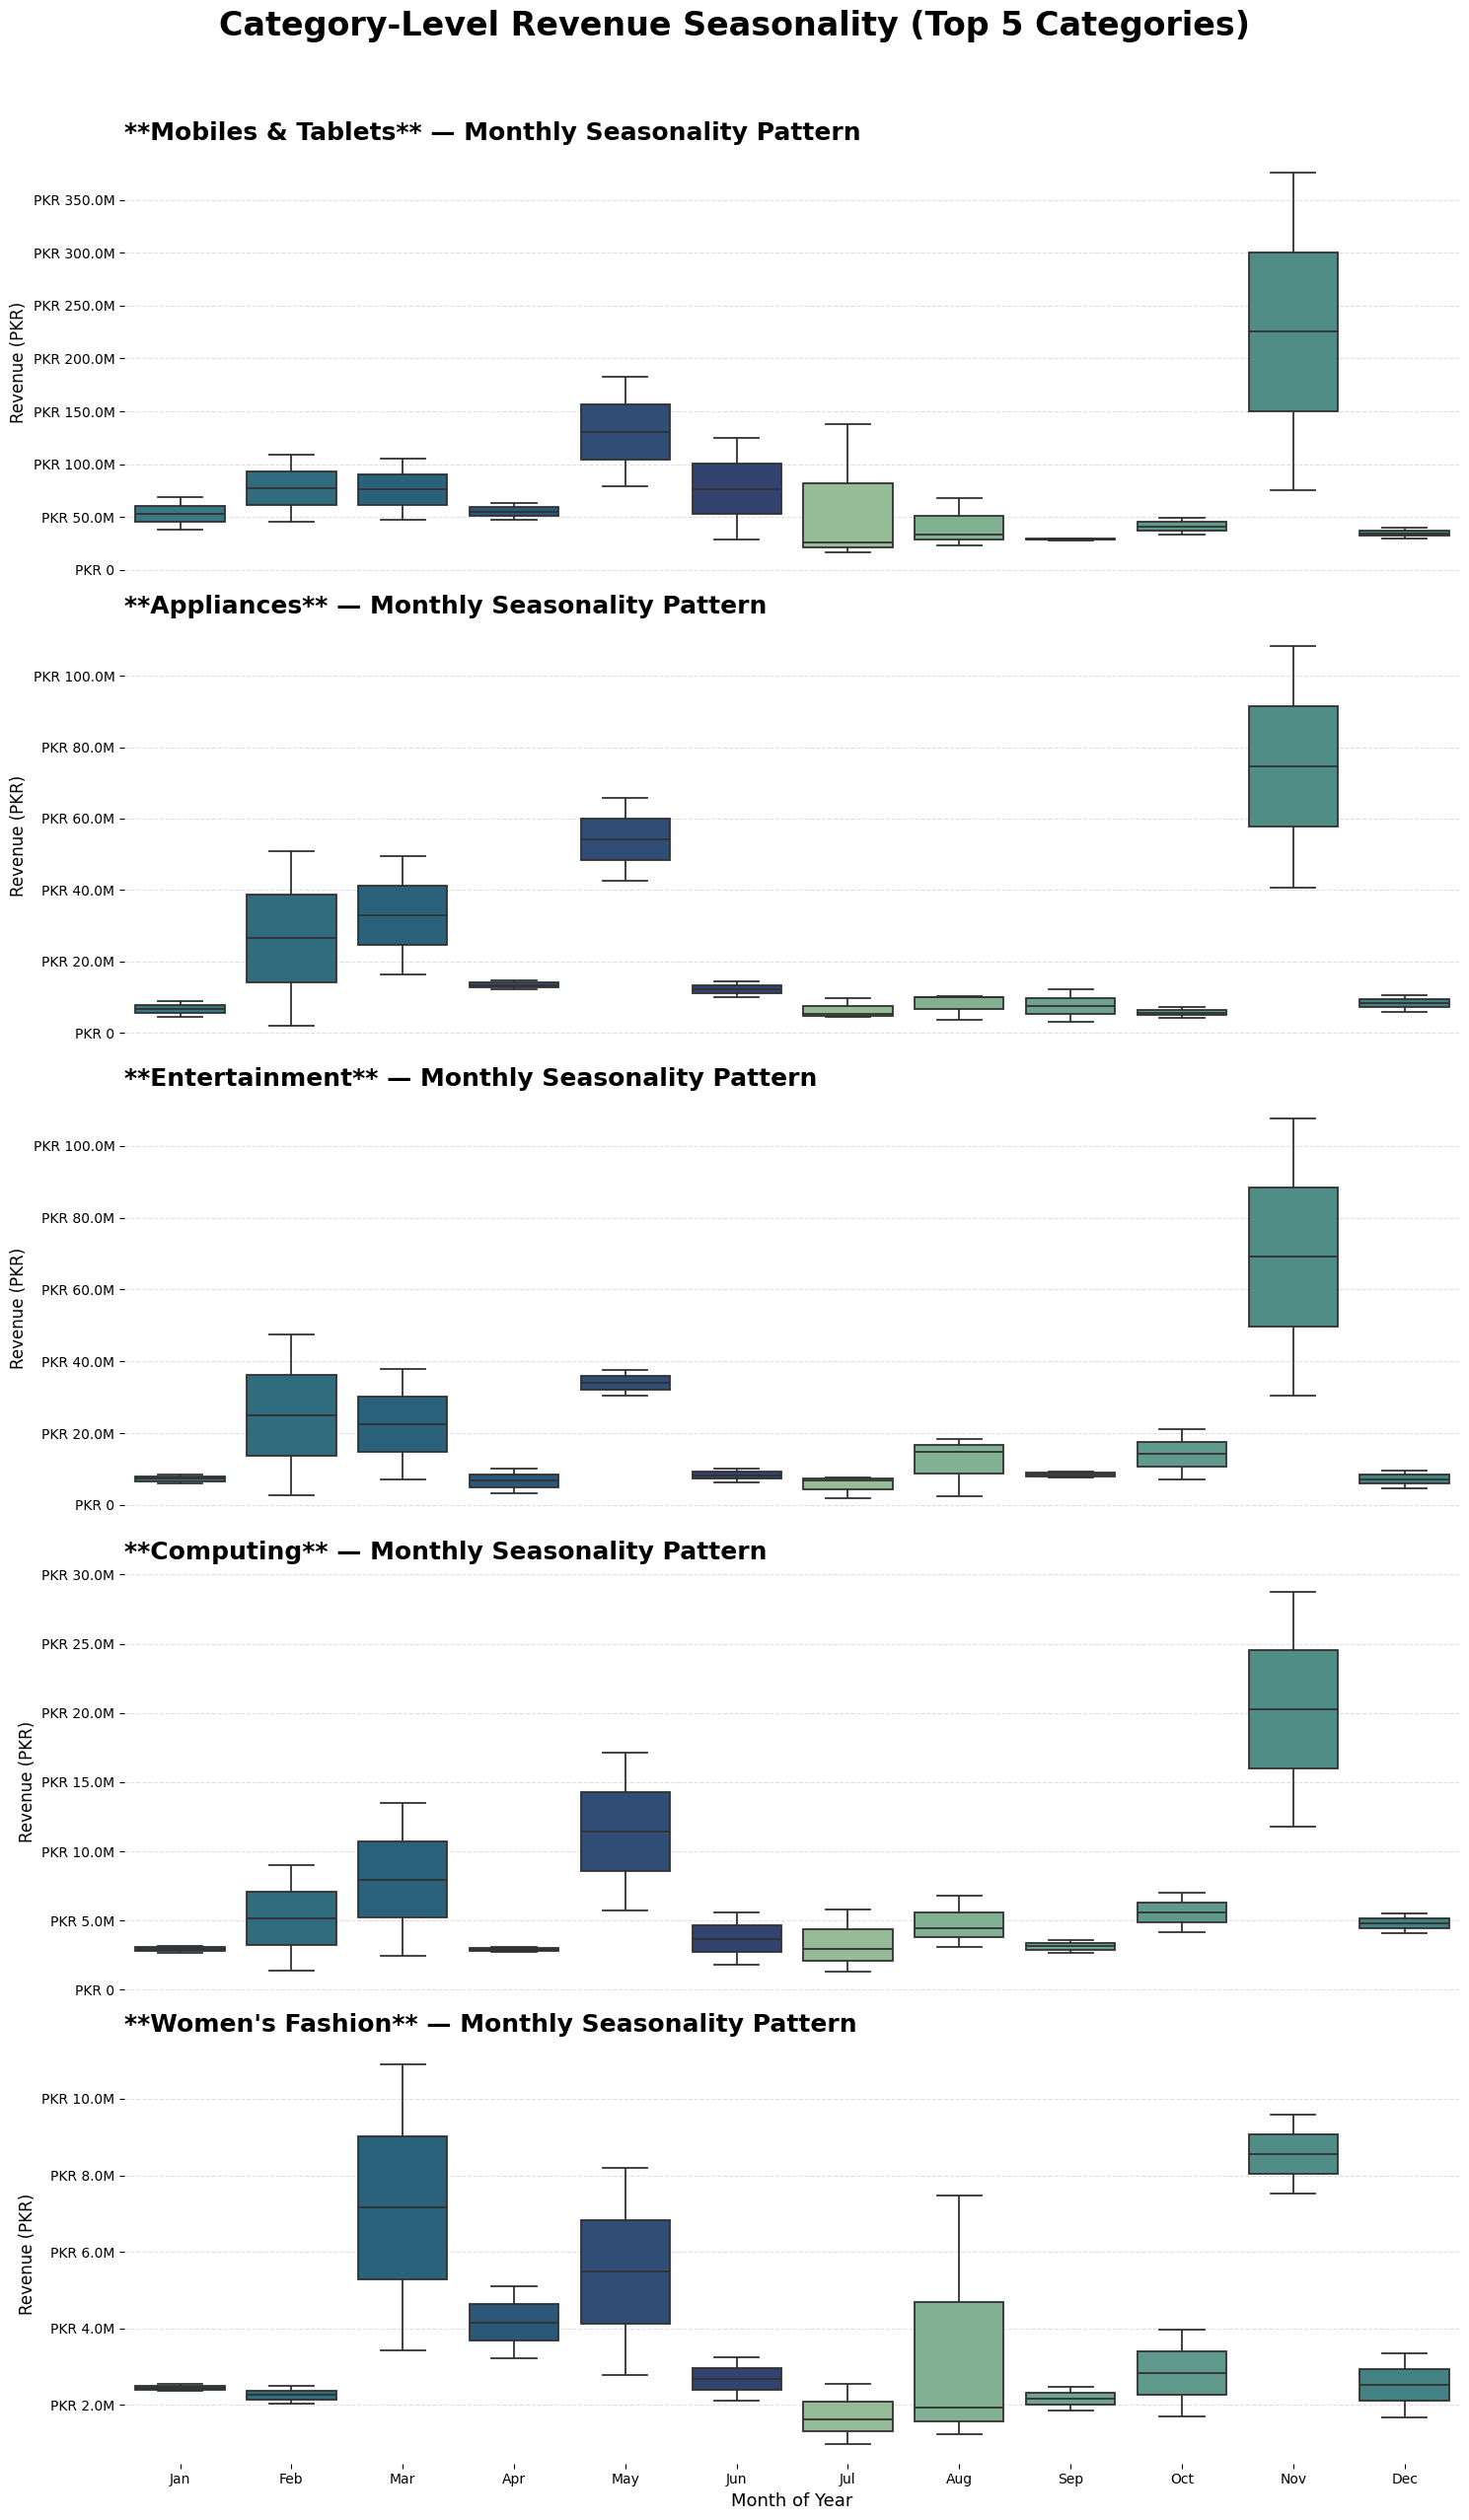

In [60]:
# --- 3 Boxplots of Monthly Seasonality  ---
month_order = [calendar.month_abbr[i] for i in range(1, 13)]
N_CATEGORIES = len(top_5_categories)
fig, axes = plt.subplots(
    nrows=N_CATEGORIES, ncols=1,
    figsize=(15, 5 * N_CATEGORIES),
    sharex=True
)

# Use a clean, consistent color palette
palette = sns.color_palette("crest", n_colors=12)

for i, category in enumerate(top_5_categories):
    # Ensure ax is an array even for N_CATEGORIES=1 case
    if N_CATEGORIES == 1:
        ax = axes
    else:
        ax = axes[i]

    df_plot = df_monthly_category_revenue[
        df_monthly_category_revenue['category_name_1'] == category
    ]

    sns.boxplot(
        data=df_plot,
        x='Month_Name',
        y='Monthly_Revenue',
        hue='Month_Name',
        order=month_order,
        ax=ax,
        palette=palette,
        linewidth=1.3,
        fliersize=3
    )

    # --- Title & Labels ---
    ax.set_title(f"**{category}** — Monthly Seasonality Pattern", fontsize=18, loc='left', fontweight='bold', pad=10)
    ax.set_ylabel("Revenue (PKR)", fontsize=12)
    if i < N_CATEGORIES - 1:
        ax.set_xlabel('')
        ax.tick_params(axis='x', bottom=False)
    else:
        ax.set_xlabel("Month of Year", fontsize=13)

    # Currency formatting for Y-axis
    def format_currency(x, pos):
        if x >= 1e6:
            return f'PKR {x/1e6:,.1f}M'
        elif x >= 1e3:
            return f'PKR {x/1e3:,.0f}K'
        return f'PKR {int(x):,}'
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_currency))

    # Grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    sns.despine(ax=ax, left=True, bottom=True)
    
    # Manually remove the legend after plotting, if it appeared
    if ax.legend_:
        ax.legend_.remove()


plt.suptitle(
    "Category-Level Revenue Seasonality (Top 5 Categories)",
    fontsize=24, fontweight='semibold', y=1.02
)
plt.tight_layout()
plt.savefig('category_seasonality_top5.png', dpi=300)
plt.show()

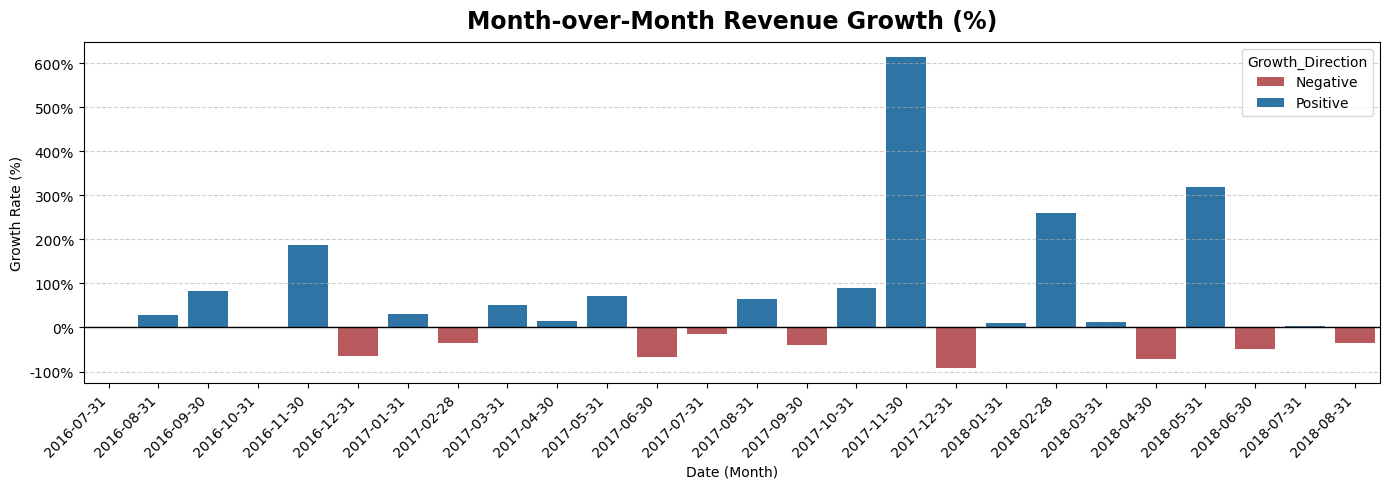

In [61]:
# --- Data Preparation for Coloring  ---
# Create a new column to determine the color based on positive/negative growth
df_monthly_sales['Growth_Direction'] = df_monthly_sales['Monthly_Growth_%'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')

# --- Month-over-Month Growth Visualization ---
plt.figure(figsize=(14, 5))
ax = sns.barplot(
    data=df_monthly_sales,
    x='Date',
    y='Monthly_Growth_%',
    # ---  Use hue for direction-based coloring ---
    hue='Growth_Direction',
    palette={'Positive': '#1f77b4', 'Negative': '#C44E52'},
    saturation=0.8
)

plt.axhline(0, color='black', linewidth=1)
plt.title("Month-over-Month Revenue Growth (%)", fontsize=17, fontweight='bold', pad=10)
plt.xlabel("Date (Month)")
plt.ylabel("Growth Rate (%)")

# Ensure date labels are not truncated
plt.xticks(rotation=45, ha='right')

# Add y-axis label formatting as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}%'))

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('monthly_revenue_growth.png', dpi=300)
plt.show()

In [62]:
# Save the final analytical tables to CSV files
print("--- Exporting Final Analytical DataFrames ---")

# 1. Export the Customer-Level RFM Table
df_rfm.to_csv('final_customer_rfm_analysis.csv', index=False)
print("Saved final_customer_rfm_analysis.csv (Customer-level data with RFM scores)")

# 2. Export the Clean Order-Level Transactional Table
# Exclude the temporary date features that might be redundant, keeping core features.
df_orders_export = df_orders[['Order_Group_ID', 'created_at', 'grand_total', 'Customer ID', 'status_group', 'Order_Size', 'Order_Discount_Rate']].copy()
df_orders_export.to_csv('final_clean_orders_data.csv', index=False)
print("Saved final_clean_orders_data.csv (Cleaned Order-level data)")

# 3. Export real clean data
df.to_csv('final_clean_item_data.csv', index=False)
print("Saved final_clean_item_data.csv (Cleaned Item-level data)")

print("\nProject files successfully exported. Project ready for closure or handover.")

--- Exporting Final Analytical DataFrames ---
Saved final_customer_rfm_analysis.csv (Customer-level data with RFM scores)
Saved final_clean_orders_data.csv (Cleaned Order-level data)
Saved final_clean_item_data.csv (Cleaned Item-level data)

Project files successfully exported. Project ready for closure or handover.
